# COMS6998 Final Report
Liushiya Chen $\quad$ Peimou Sun

In [1]:
%matplotlib inline
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import pyro
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
import util

## 1. Problem statement and data description

**Data:**

Instacart order data. The data set consists of a set of orders, and each order is a set of products. For each product, we know its name, department, and aisle number. The data include 49,688 types of products and 1,384,617 records of purchased products.

**Preprocessing:**

The product names are lightly preprocessed to reduce the number of unique items:
1. Only the last two words of each product name is kept. This gives us a good idea of what most items are and drops detailed descriptions.
2. We used a manually created list of "stopwords" to remove words that are not descriptive (e.g. "oz", "gallon", "ct", "lb")

Examples: "Mexican Big Green Organic Avocados" to "Organic Avocados" and "1 Gallon Milk" to "Milk"

In [3]:
# Peimou problem statement
# Shiya data description

In [30]:
s = pd.Series((' '.join(data.apply(' '.join)).split(' ')))

In [84]:
pd.set_option('display.max_colwidth', 60)
pd.DataFrame(data.rename('products'))

,products
order_id,
98,"[spring water, vitamin d, bean yogurt, organic bananas, ..."
170,"[salad dressing, seedless grapes, organic bananas, chopp..."
349,"[irish butter, almond milk, breakfast sausage, sunday ba..."
631,"[organic strawberries, genoa salami, baby carrots, corn ..."
878,"[banana, vanilla yogurt, honeycrisp apple, baby spinach,..."
...,...
33202,"[tea pyramids, organic blackberries, relief tea, size ca..."
33315,"[raisin bagels, hass avocados, soda, fruit snacks, organ..."
33331,"[organic banana, seedless grapes, squeezers tubes, plain..."


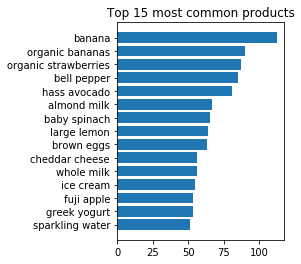

In [83]:
_, data, _ = util.load_process()
data = data.head(500)

prod = pd.Series('|'.join(data.apply('|'.join)).split('|'))
prod_count = prod.value_counts().head(15).iloc[::-1]
plt.figure(figsize=(3, 4))
plt.barh(prod_count.index, prod_count)
plt.title('Top 15 most common products')
plt.show()

## 2. LDA model

In [ ]:
# theta and z. The data generation process
# Peimou

## 3. Inference

In [ ]:
# two implementation. Guide and cavi, bbvi

### 3.1 BBVI

In [15]:
from ldavi import bbvi
from pyro.optim import ClippedAdam

n_topics = 5
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 20
n_particles = 1

ldabb = bbvi.LDABBVI(data, ClippedAdam, n_topics=n_topics)
loss = ldabb.run_svi(n_steps=n_steps, opt_params=opt_params, verbose=True)

plt.plot(loss)
plt.show()

0% (140538.1) | 5% (140782.5) | 10% (138683.8) | 15% (138599.2) | 20% (138971.4) | 

RuntimeError: python_error

### 3.2 CAVI

In [ ]:
# peimou

## 4. Criticism

### 4.1 Model criticism

In [ ]:
# why lda behave like this. Peimou

### 4.2 Inference criticism

**1. Monte Carlo Integration Variance**

When computing the ELBO gradient at each step, we are trying to estimate a quantity of the following form:

$$\nabla_{\phi}\mathbb{E}_{q_{\phi}({\bf z})} \left [f_{\phi}({\bf z}) \right]$$

Before we can move the $\nabla$ into the expectation, we need to remove the dependency of $q(z)$ on $\phi$. This can be done by reparametrization, which is easy for LDA because the PDF of dirichlet and categorical are continuous w.r.t. their parameters.

$$\nabla_{\phi}\mathbb{E}_{q({\bf \epsilon})} \left [f_{\phi}(g_{\phi}({\bf \epsilon})) \right]=
\mathbb{E}_{q({\bf \epsilon})} \left [\nabla_{\phi}f_{\phi}(g_{\phi}({\bf \epsilon})) \right]$$

The issue, however, is that the number of latent variables $z_{d,w}$ grows linearly with number of observations, and usually we need at least tens of thousands of observation to obtain sensible results. This greatly increases the variance of the MC integration estimate.

$$\mathbb{E}_{q(z)}[f(z)] \approx \frac{1}{S}\sum^S_i f(z_i) \text{ where } f(z) = z^2$$

In the next few cells, we will demonstrate with a few toy examples how high-dimensional support for $q(z)$ can affect the variance of the estimate.

finished: 
2 5 7 100 300 600 1000 

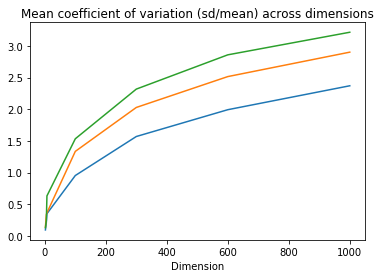

In [75]:
dims = [2, 5, 7, 100, 300, 600, 1000]
q = dist.Dirichlet
funcs = [
    lambda x: np.sin(x),
    lambda x: np.power(x, 2),
    lambda x: np.power(x, 3),
]

util.run_mc_experiment(dims, funcs, q, n_trials=20, n_samples=100)

**2. Simultaneous Parameter Update**

This is again linked to the high dimensionality of the latent variables. Since the number of parameters is proportionate to the number of latent variables, BBVI needs to update a large number of parameters in each step.

Since the high variance of the ELBO gradient is 

A potential issue is that to increment all $d$ parameters by Δ for example, we will need a vector (Δ, ..., Δ) $\in\mathbb{R}^d$. The norm of this vector is Δ$\sqrt{d}$ which can be quite large as $d$ grows with observations, so it will require a similarly large learning rate. This is fine if the gradient estimate is accurate. However, our gradient estimate is noisy and it is possible to take very large steps in a few dimensions. This results in instability in our parameters.

## 5. Improvement

## Reference